In [1]:
import numpy as np
#%matplotlib inline
%matplotlib notebook
%matplotlib notebook
import matplotlib.pyplot as plt

np.random.seed(1)
import tqdm


Sigmoid neurons

In [2]:
d = 2 # dimension of space
M = 2 # number of neurons for generation

In [3]:
def sigma(x):
    return (1. / (1. + np.exp(-x)))

In [4]:
class Neuron:
    def __init__(self):
        self.a = np.random.normal(loc = 0., scale = 1.)
        self.w = np.random.normal(size = d)
        self.b = np.random.normal(loc = 0., scale = 1.)
    def set_weights(self, a, w, b):
        self.a = a
        self.w = w
        self.b = b
    def forward(self, x):
        return self.a * sigma(self.w.dot(x) + self.b)

In [5]:
class Network:
    def __init__(self, width):
        self.width = width
        self.neurons = [Neuron() for i in range(width)]
    def zero_out(self):
        for nr in self.neurons:
            nr.set_weights(0., nr.w, nr.b)
    def zero_bias(self):
        for nr in self.neurons:
            nr.set_weights(nr.a, nr.w, 0)
    def output(self, x):
        return np.mean([n.forward(x) for n in self.neurons])
    def loss(self, x, y):
        return .5*(self.output(x) - y)**2
    def grad(self, x, y):
        d = (self.output(x) - y)
        s = np.array([sigma(n.w.dot(x) + n.b) for n in self.neurons])
        ga = 1./self.width * d * s
        gb = 1./self.width * d * np.array([self.neurons[i].a*s[i]*(1-s[i]) for i in range(self.width)])
        gw = np.array([gb[i] * x for i in range(self.width)]) # shape m * d
        return ga, gw, gb
    def step(self, x, y, tau):
        ga, gw, gb = self.grad(x, y)
        for i in range(self.width):
            nr = self.neurons[i]
            a_new = nr.a - tau * ga[i]
            w_new = nr.w - tau * gw[i]
            b_new = nr.b - tau * gb[i]
            nr.set_weights(a_new, w_new, b_new)
    def batch_step(self, X, Y, tau):
        ba = X.shape[0]
        Ga, Gw, Gb = np.zeros((ba, self.width)), np.zeros((ba, self.width, d)), np.zeros((ba, self.width))
        for i in range(ba):
            Ga[i], Gw[i], Gb[i] = self.grad(X[i], Y[i])
        ga, gw, gb = Ga.sum(axis = 0), Gw.sum(axis = 0), Gb.sum(axis = 0)
        for i in range(self.width):
            nr = self.neurons[i]
            a_new = nr.a - tau * ga[i]
            w_new = nr.w - tau * gw[i]
            b_new = nr.b - tau * gb[i]
            nr.set_weights(a_new, w_new, b_new)
    def sgd_train(self, X, Y, tau, epochs, batch, disp = True):
        for e in range(epochs):
            pm = np.random.permutation(X.shape[0])
            X = np.array([X[pm[i]] for i in range(X.shape[0])])
            Y = np.array([Y[pm[i]] for i in range(Y.shape[0])])
            if batch > 1:
                nbatch = X.shape[0]//batch
                subX = np.split(X, nbatch)
                subY = np.split(Y, nbatch)
                for s in range(len(subX)):
                    self.batch_step(subX[s], subY[s], tau)
            else:
                for i in range(X.shape[0]):
                    self.step(X[i], Y[i], tau)
            loss = self.test(X, Y)
            if disp:
                print('epoch '+str(e)+' : '+str(loss))
        return loss
    def test(self, X_t, Y_t):
        ts = X_t.shape[0]
        return np.mean([self.loss(X_t[i], Y_t[i]) for i in range(ts)])
    def gen_sample(self, R, s = 1):
        if s==1:
            X = np.random.normal(size = d)
            # see one which it should be
            X = R * X / np.linalg.norm(X, 2)
            #X = R * X / np.sqrt(1. + np.linalg.norm(X, 2)**2)
            Y = self.output(X)
            return X, Y
        else:
            X = np.random.normal(size = (s, d))
            Y = np.zeros(s)
            for i in range(s):
                # see one which it should be
                #X[i] = R * X[i] / np.sqrt(1. + np.linalg.norm(X[i], 2)**2)
                X[i] = R* X[i] / np.linalg.norm(X[i], 2)
                Y[i] = self.output(X[i])
            return X, Y
    def give_weights(self):
        la, lw, lb = np.zeros(self.width), np.zeros((self.width, d)), np.zeros(self.width)
        for i in range(self.width):
            nr = self.neurons[i]
            la[i] = nr.a
            lw[i] = nr.w
            lb[i] = nr.b
        return la, lw, lb
    def display_weights(self, fig, ax, true_w = None, color='b'):
        assert d==2, 'must be in dimension 2'
        ax.cla()
        ax.set_xlim((-3, 3))
        ax.set_ylim((-3, 3))
        la, lw, _ = self.give_weights()
        xp, yp, sp, xn, yn, sn = [],[],[],[],[],[]
        la = la / np.linalg.norm(la, 2)
        for k in range(self.width):
            if la[k] >=0:
                xp.append(lw[k, 0])
                yp.append(lw[k, 1])
                sp.append(100 * la[k])
            else:
                xn.append(lw[k, 0])
                yn.append(lw[k, 1])
                sn.append(-100 * la[k])
        pos = ax.scatter(xp, yp, s = sp, color='r')
        neg = ax.scatter(xn, yn, s = sn, color='b')
        if true_w is not None:
            tla, tlw, _ = true_w
            tx, ty = np.zeros(tla.shape[0]), np.zeros(tla.shape[0])
            for k in range(tla.shape[0]):
                tx[k] = tlw[k, 0]
                ty[k] = tlw[k, 1]
                u = np.linspace(-3, 3., 10)
                v = ty[k]/tx[k] * u
                ax.plot(u, v, color = 'g')
        fig.canvas.draw()
        #del pos
        #del neg
        return xp, yp, xn, yn

<IPython.core.display.Javascript object>


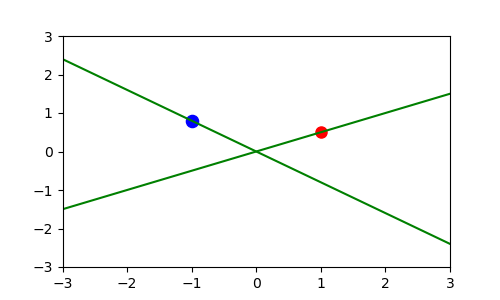

In [6]:
fig, ax = plt.subplots(figsize=(5, 3))
gen_net = Network(M)
#gen_net.zero_bias()
gen_net.neurons[0].set_weights(1, np.array([1, 0.5]), -0.2)
gen_net.neurons[1].set_weights(-1.2, np.array([-1, 0.8]), 0.4)

true_w = gen_net.give_weights()
xp, yp, xn, yn = gen_net.display_weights(fig, ax, color='g', true_w = true_w)
ax.scatter(xp, yp, s = 10., color='r')
ax.scatter(xn, yn, s = 10., color='b')

Initialize new network with parameter a = 0 and data on the sphere.

In [7]:
net = Network(50)
net.zero_out()

<IPython.core.display.Javascript object>


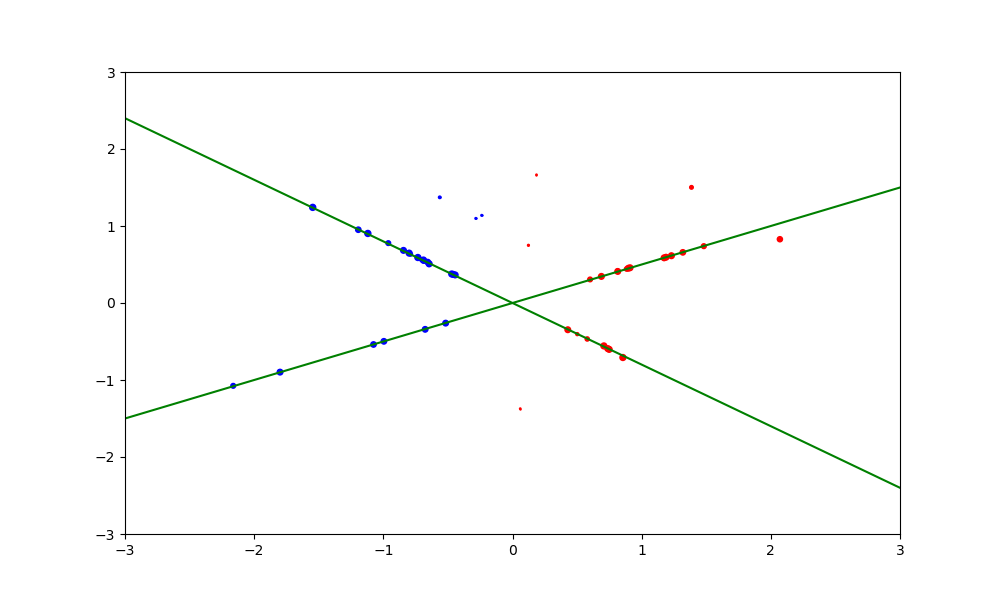

In [8]:
fig, ax = plt.subplots(figsize=(10, 6))
for i in range(500):
    X, Y = gen_net.gen_sample(R = 100, s = 150)
    net.sgd_train(X, Y, tau = .1, batch = 50, epochs = 1, disp = False)
    X_t, Y_t = gen_net.gen_sample(50)
    #print('test', net.test(X_t, Y_t))
    xp, yp, xn, yn = net.display_weights(fig, ax, true_w = true_w)
    ax.scatter(xp, yp, s = .5, color='r')
    ax.scatter(xn, yn, s = .5, color='b')

Ill conditioning on the input data is a plague!

What is the influence of:
    - the size of the input data weights sphere / dimension of the sphere (include 1 or not) ?
    - the number of units ?
    - the original problem configuration ?

Find a way to store trajectories and generate a pretty gif